In [20]:
import pandas as pd
import numpy as np
from pathlib import Path
import scanpy as sc
from anndata import AnnData
import seaborn as sns
from matplotlib import rc

rc('font',**{'family':'sans-serif',
             'sans-serif':['Arial'],
             'size':16})

- Inputs

In [21]:
p_root_dir = Path(r"D:\saharuka\spotting\20_matrices_git\spotting\analysis\interlab\interlab_data_from_Mans")
p_data = p_root_dir #/ "5_data_analysis"
p_out = p_root_dir #/ "6_plots/q2_plots/dot_plots"

# Metrics and Catboost predictions for all ions in their target wells
p_predictions = p_data / "All_Interlab_Predictions.csv"

# Dataset info (lab, matrix, polarity, m/z range, ids, etc.)
p_datasets = p_data / "All_Datasets.csv"

# Classification
p_chem_class = p_data / "custom_classification_v2.csv"

- Merge relevant info into one dataframe

In [22]:
def filter_neutral_losses(df, filter_on=True, neutral_losses_to_keep=['']):
    '''
    Filter out entries for ions with neutral losses that are not in the list provided
    '''
    if filter_on==True:
        df = df[df.neutral_loss.isin(neutral_losses_to_keep)]
    elif filter_on == 'only_nl':
        df = df[df.neutral_loss != '']
    return df

def filter_adducts(df, filter_on=True, adducts_to_keep=['']):
    '''
    Filter out entries for ions with adducts that are not in the list provided
    '''
    if filter_on==True:
        df = df[df.adduct.isin(adducts_to_keep)]
    return df


def filter_polarity(df, filter_on=True, polarity=None):
    '''
    Filter out entries based on polarity pol ['pos', 'neg']
    '''
    if filter_on==True:
        df = df[df['Polarity'] == polarity]
    return df

def group_by_molecule(df, prediction_col_name):
    '''
    Aggregate intensity and detection values per class, keep polarity
    '''
    
    if prediction_col_name == 'pred_threestate':
        aggregation_func = lambda x: (x==2).any()
    else: aggregation_func = lambda x: (x==1).any()
            
    
    data = df.pivot_table(columns=['name_short'],
                          index=['dataset_id'],
                          values=[prediction_col_name],
                          aggfunc = aggregation_func,
                          fill_value=False,
                          sort=False)
    return data

def prep_pca_data(data, polarity_filter_on, prediction_col_name, polarity=None, adduct_filter_on=False, adducts_to_keep=None, nl_filter_on=False, neutral_losses_to_keep=None):
    '''
    '''
    
    data = filter_adducts(data, adduct_filter_on, adducts_to_keep)
    data = filter_neutral_losses(data, nl_filter_on, neutral_losses_to_keep)
    data = filter_polarity(data, polarity_filter_on, polarity)
    data = group_by_molecule(data, prediction_col_name)
    
    return data

In [23]:
# Load predictions, format neutral loss column
predictions = pd.read_csv(p_predictions, index_col=0)
predictions.neutral_loss.fillna('', inplace=True)

chem_class = pd.read_csv(p_chem_class, index_col='internal_id')
main_chem_class = chem_class[['name_short', 'main_coarse_class']].drop_duplicates()

# Get a subset of most relevant information from Datasets file
datasets = pd.read_csv(p_datasets)
datasets_info = datasets.groupby('Dataset ID').first()[['Polarity', 'Matrix short', 'Matrix long', 'Slide code', 'Technology', 'Participant lab', 'Primary', 'Source Type', 'Analyzer', 'Source Pressure']]

# # Merge with predictions and classification
df = pd.merge(predictions, datasets_info, left_on='dataset_id', right_on='Dataset ID', how='left')
df = df[(df['Technology'] != 'MALDI2-qTOF')]# & (df['Primary']==1)]

## Option 1: Build PCA based on the intenisities and detectability of all metabolites
- Each metabolite is an average of its detected ions

In [46]:
# Summarise data per molecule (intensities of its detected ions are summed)
pca = prep_pca_data(df,
                    polarity_filter_on=True,
                    polarity='Pos',
                    adduct_filter_on=False,
#                     adducts_to_keep=None,
                    nl_filter_on=True, 
                    neutral_losses_to_keep=[''], 
                    prediction_col_name = 'pred_threestate'
                             )

adata = AnnData(pca,
               obs = datasets_info.loc[pca.index])

# # Apply Z-score normalisation
sc.pp.scale(adata, zero_center=True)

# Compute and plot PCA
sc.tl.pca(adata, svd_solver='arpack')

... storing 'Polarity' as categorical
... storing 'Matrix short' as categorical
... storing 'Matrix long' as categorical
... storing 'Slide code' as categorical
... storing 'Technology' as categorical
... storing 'Participant lab' as categorical
... storing 'Source Type' as categorical
... storing 'Analyzer' as categorical
... storing 'Source Pressure' as categorical


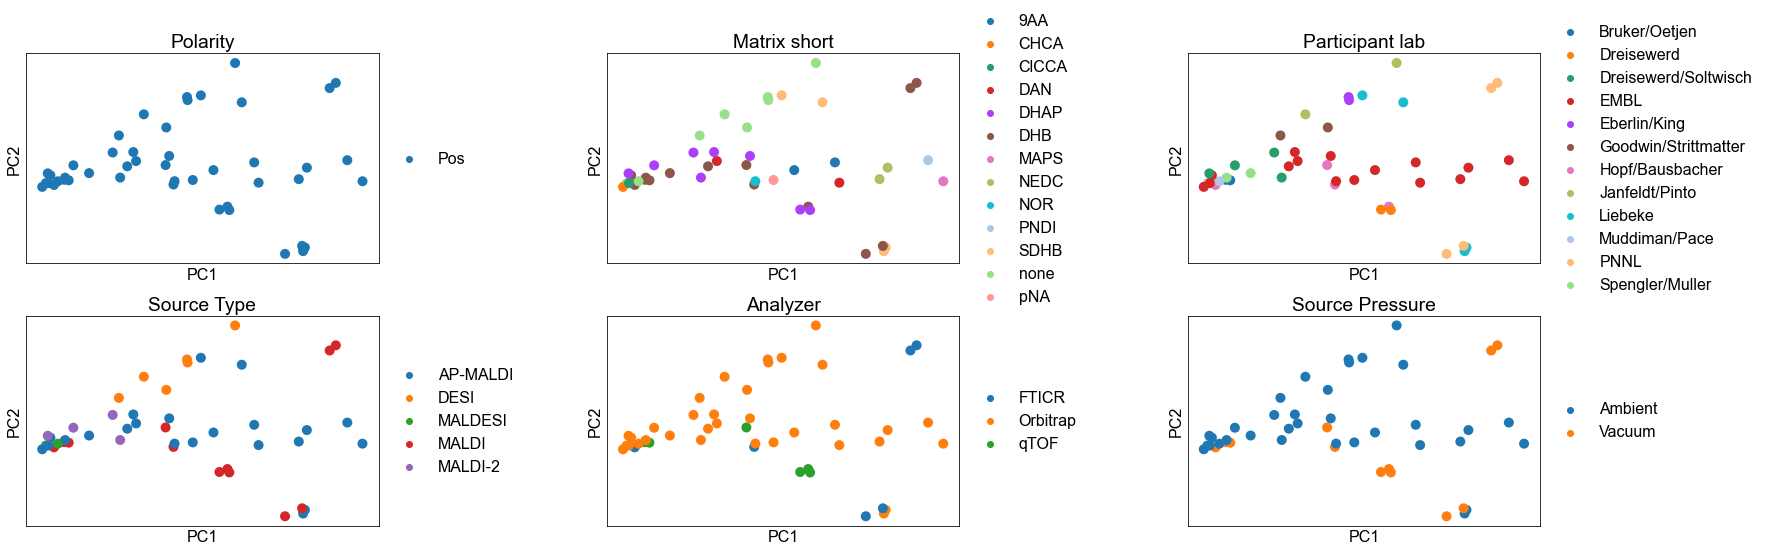

In [47]:
sc.pl.pca(adata, components=['1,2'], 
          color=['Polarity', 'Matrix short', 'Participant lab',  'Source Type', 'Analyzer', 'Source Pressure'], 
          size=400, ncols=3, wspace=0.5)

## Option 2: PCA based on the aggregated values also used in coarse class dot plot
- This is useful in case you want to see PCA loadings

In [26]:
def summarise_per_coarse_class(df, class_col_name, prediction_col_name):
    
    df['class_size'] = 1
    data = df.pivot_table(index=['dataset_id'],
                                   columns=class_col_name,
                                   values=[prediction_col_name, 'class_size'],
                                   aggfunc = {
                                        'class_size':sum,
                                        prediction_col_name : sum
                                   },
                                   fill_value=0,)
    
    data = data.stack(level=1, dropna=False).reset_index()
    data['fraction_detected'] = data[prediction_col_name] / data['class_size']
    
    
    # sort columns alphabetically
    data = data.sort_values(by='dataset_id')    
    return data

In [27]:
# Summarise data per molecule (intensities of its detected ions are summed)
molecule_data = prep_pca_data(df,
                   polarity_filter_on=True,
                   polarity='Neg',
                   adduct_filter_on=False,
                   adducts_to_keep=None,
                   nl_filter_on=True, 
                   neutral_losses_to_keep=[''], 
                   prediction_col_name = 'pred_threestate').stack(level=1).reset_index()

# Map chemical classes
mapped_data = molecule_data.merge(main_chem_class, on='name_short', how='left') #chem_class of pathways

# # Summarise data per class
class_data = summarise_per_coarse_class(mapped_data,
                                        class_col_name='main_coarse_class',
                                        prediction_col_name = 'pred_threestate')

# Reshape into AnnData
pca = class_data.pivot_table(values='fraction_detected', 
                       index='dataset_id', 
                       columns='main_coarse_class')
adata = AnnData(pca,
               obs = datasets_info.loc[pca.index])

# # Apply Z-score normalisation
# sc.pp.scale(adata, zero_center=True)

# # Compute and plot PCA
sc.tl.pca(adata, svd_solver='arpack')

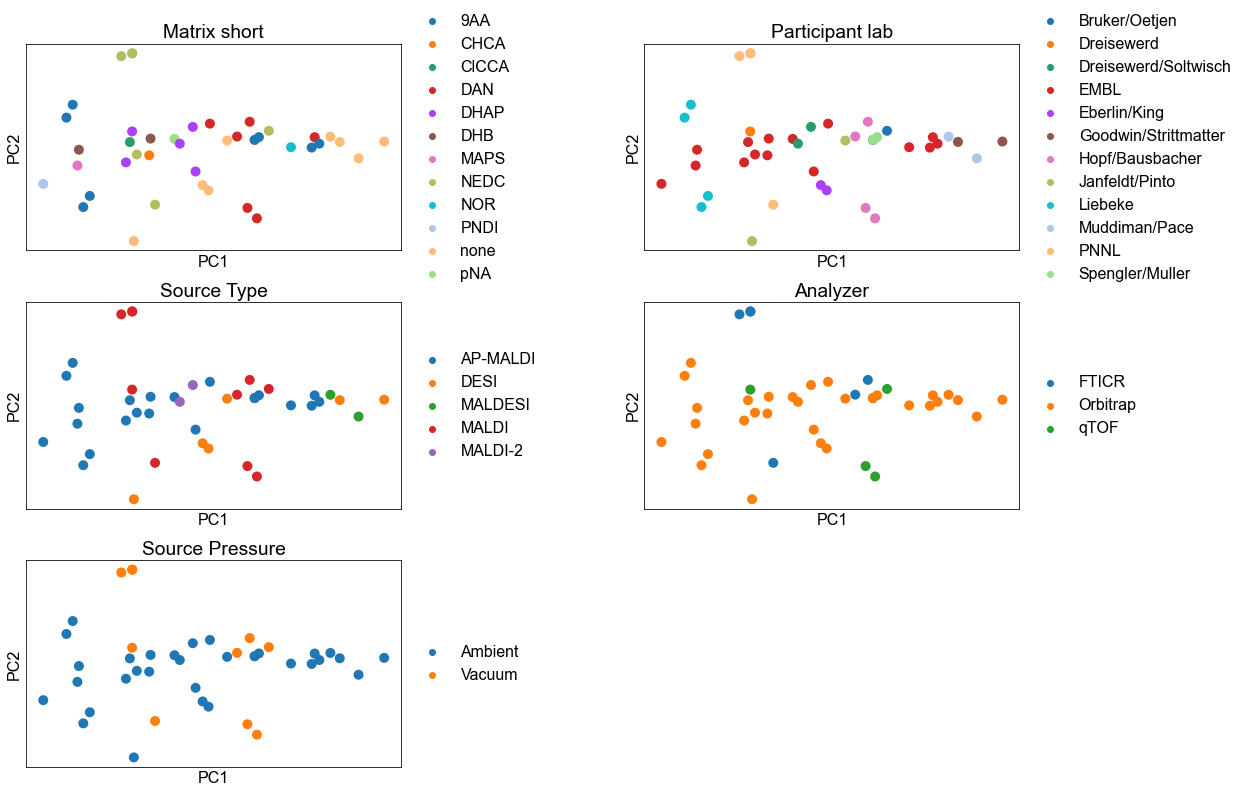

In [42]:
sc.pl.pca(adata, components=['1,2'], 
          color=['Matrix short', 'Participant lab',  'Source Type', 'Analyzer', 'Source Pressure'], 
          size=400, ncols=2, wspace=0.5)

In [43]:
# # Extras

# # See how much PCA components explain variance
# sc.pl.pca_variance_ratio(adata)

# # Check loading plot
# sc.pl.pca_loadings(adata, components='1,2')

## Option 3: PCA based on the aggregated values also used in fine class dot plot
- All three opotions provide similar result, but this can be useful for the loading plot

In [30]:
def summarise_per_fine_class(df, fine_class_col_name, coarse_class_col_name, prediction_col_name):
    
    df['class_size'] =1
    data = df.pivot_table(index=['dataset_id'],
                                   columns=[fine_class_col_name, coarse_class_col_name],
                                   values=[prediction_col_name, 'class_size'],
                                   aggfunc = {
                                        'class_size':sum,
                                        prediction_col_name : sum,
                                   },
                                   fill_value=0,
                                   sort=False)
    
    data = data.stack(level=[1,2], dropna=True).reset_index()
    data['fraction_detected'] = data[prediction_col_name] / data['class_size']    
    
    # sort columns alphabetically
    data = data.sort_values(by='dataset_id')
    # sort rows first by coarse class, then by fine class
    data = data.sort_values(by=[coarse_class_col_name, fine_class_col_name])
    return data


In [31]:
# Summarise data per molecule (intensities of its detected ions are summed)
molecule_data = prep_pca_data(df,
                              polarity_filter_on=True,
                              polarity='Neg',
                                   adduct_filter_on=False,
                                   adducts_to_keep=None,
                                   nl_filter_on=True, 
                                   neutral_losses_to_keep=[''],
                                   prediction_col_name = 'pred_threestate').stack(level=1).reset_index()

# Map chemical classes
mapped_data = molecule_data.merge(chem_class, on='name_short', how='left') #pathways or chem_class

# Summarise data per class
class_data = summarise_per_fine_class(mapped_data,
                                      fine_class_col_name='fine_class',
                                      coarse_class_col_name='coarse_class',
                                      prediction_col_name = 'pred_threestate')

# Reshape into AnnData
pca = class_data.pivot_table(values='fraction_detected', 
                       index='dataset_id', 
                       columns='fine_class')

adata = AnnData(pca,
               obs = datasets_info.loc[pca.index])

# Apply Z-score normalisation
sc.pp.scale(adata, zero_center=True)

# Compute and plot PCA
sc.tl.pca(adata, svd_solver='arpack')

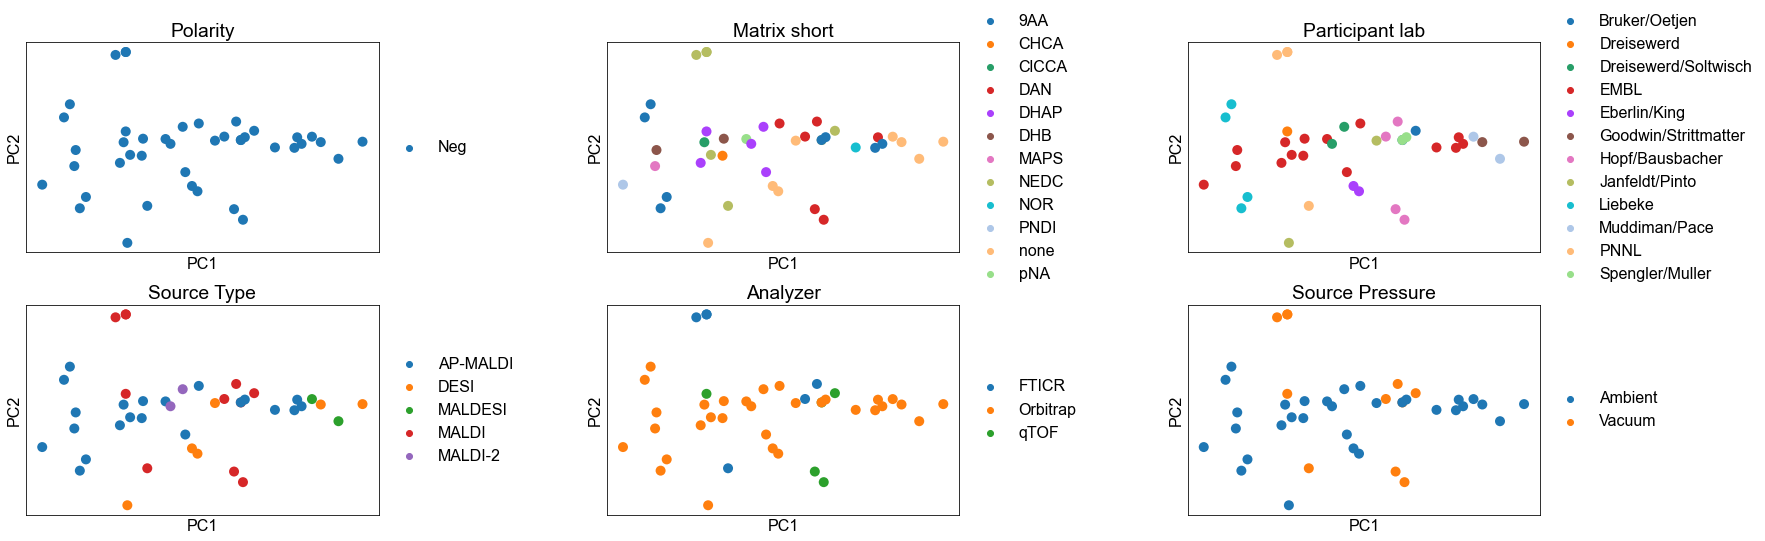

In [44]:
sc.pl.pca(adata, components=['1,2'], 
          color=['Polarity', 'Matrix short', 'Participant lab',  'Source Type', 'Analyzer', 'Source Pressure'], 
          size=400, ncols=3, wspace=0.5)

In [ ]:
# Extras

# see how much PCA components explain variance
sc.pl.pca_variance_ratio(adata)

# check loading plot
sc.pl.pca_loadings(adata, components='1,2')